<a href="https://colab.research.google.com/github/MustansirVerdawala/MachineLearning/blob/main/XGBoost_Regressor%5CXGBoost_Regressor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Install dependencies
!pip install numpy>=1.17.2 pandas>=0.25.1 scikit-learn>=0.22.1 xgboost>=1.30

In [ ]:
# Necessary Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
import xgboost as xgb
from xgboost import plot_tree, plot_importance
import shap
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# Load data in
data = 'https://raw.githubusercontent.com/EvidenceN/Life-Expectancy-Prediction/master/Life%20Expectancy/Data/Life%20Expectancy%20Data.csv'

OriginalDataFrame = pd.read_csv(data)

In [ ]:
# Make copy
df = OriginalDataFrame.copy()

df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


In [ ]:
# Data exploration
%%capture
!pip install ydata-profiling
import ydata_profiling

In [ ]:
# Get a neat, interactive dashboard of the entire dataset
profile = ydata_profiling.ProfileReport(df)

In [ ]:
profile

In [ ]:
"""To keep things clean and simple, I dropped all rows with missing values.
With over 2800 rows in the dataset, losing some incomplete entries isn’t a big deal — I still have more than enough data to train a solid model.
Imputing values like GDP or population didn’t make sense since it would mean using data from one country to guess values for another, which isn't reliable.
Instead of making inaccurate assumptions or complicating things with imputation strategies, I just removed the rows.
This keeps the dataset honest and makes sure the model learns from real, complete examples.

I also dropped the 'Income composition of resources' column because it directly includes life expectancy in its calculation.
Keeping it would be data leakage — basically giving the model the answer it’s trying to predict.
That would inflate performance and defeat the whole purpose of training a model.

After running SHAP feature analysis, I found several other variables to be insignificant predictors of mortality. Those were also removed.
"""

In [ ]:
# Drop missing values
df = df.dropna()

df = df.drop(columns=['Country', 'Year', 'Income composition of resources'])

# Binarize
df = pd.concat([df.drop('Status', axis=1), pd.get_dummies(df['Status'], drop_first=True)], axis=1)
df = df.drop(columns=['Measles ', 'Hepatitis B', 'Developing', 'Polio', 'Population', 'GDP', 'Total expenditure', 'infant deaths', 'Diphtheria '])

In [ ]:
# Replace whitespaces with _
df.columns = df.columns.str.replace(r'\s+', '_', regex=True)

In [ ]:
train_df, temp_df = train_test_split(df, test_size=0.5, random_state=53)
valid_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=53)

In [ ]:
train_df.shape, valid_df.shape, test_df.shape

((824, 10), (412, 10), (413, 10))

In [ ]:
# Normalize Scales for numerical columns

num_cols = ['Life_expectancy_', 'Adult_Mortality', 'Alcohol', 'percentage_expenditure', '_BMI_', 'under-five_deaths_', '_HIV/AIDS', '_thinness_1-19_years',
            '_thinness_5-9_years', 'Schooling']

scaler = RobustScaler()

# Fit scaler on training data ONLY
scaler.fit(train_df[num_cols])

# Transform train_df, valid_df, test_df using same scaler
train_df[num_cols] = scaler.transform(train_df[num_cols])
valid_df[num_cols] = scaler.transform(valid_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

train_df.head()
#valid_df.head()
#test_df.head()

,Life_expectancy_,Adult_Mortality,Alcohol,percentage_expenditure,_BMI_,under-five_deaths_,_HIV/AIDS,_thinness_1-19_years,_thinness_5-9_years,Schooling
2206,0.379630,0.178512,-0.134545,-0.207403,0.763069,-0.152381,0.0,-0.518519,-0.534562,0.153846
2476,-0.055556,0.218182,0.280000,1.889572,0.336728,-0.152381,1.6,0.092593,0.055300,0.102564
1387,-0.638889,0.442975,-0.442909,-0.251959,0.784793,-0.152381,0.0,-0.518519,-0.552995,-0.051282
2737,-0.388889,0.846281,0.822545,0.564085,0.372030,0.076190,0.6,-0.092593,-0.092166,0.666667
151,0.101852,-0.026446,-0.381818,0.098221,0.073320,0.076190,0.0,-0.037037,-0.036866,-0.179487


In [ ]:
def summarize_by_column(train_df, valid_df, test_df):
    print("=== COLUMN-WISE SUMMARY ACROSS SPLITS ===")

    all_cols = train_df.columns

    for col in all_cols:
        print(f"\n→ {col}")
        if pd.api.types.is_numeric_dtype(train_df[col]):
            print(f"  Train : {train_df[col].mean():.2f} ± {train_df[col].std():.2f}")
            print(f"  Valid : {valid_df[col].mean():.2f} ± {valid_df[col].std():.2f}")
            print(f"  Test  : {test_df[col].mean():.2f} ± {test_df[col].std():.2f}")
        else:
            print("  Value Counts (%):")
            print("    Train:")
            print(train_df[col].value_counts(normalize=True).round(3).to_string().replace("\n", "\n      "))
            print("    Valid:")
            print(valid_df[col].value_counts(normalize=True).round(3).to_string().replace("\n", "\n      "))
            print("    Test :")
            print(test_df[col].value_counts(normalize=True).round(3).to_string().replace("\n", "\n      "))

# Run it
summarize_by_column(train_df, valid_df, test_df)

=== COLUMN-WISE SUMMARY ACROSS SPLITS ===

→ Life_expectancy_
  Train : -0.21 ± 0.81
  Valid : -0.32 ± 0.82
  Test  : -0.21 ± 0.81

→ Adult_Mortality
  Train : 0.12 ± 0.83
  Valid : 0.17 ± 0.85
  Test  : 0.20 ± 0.81

→ Alcohol
  Train : 0.12 ± 0.59
  Valid : 0.08 ± 0.58
  Test  : 0.11 ± 0.58

→ percentage_expenditure
  Train : 1.14 ± 3.48
  Valid : 0.96 ± 3.23
  Test  : 0.82 ± 2.86

→ _BMI_
  Train : -0.15 ± 0.55
  Valid : -0.17 ± 0.52
  Test  : -0.15 ± 0.53

→ under-five_deaths_
  Train : 1.56 ± 6.32
  Valid : 1.58 ± 5.88
  Test  : 1.43 ± 6.31

→ _HIV/AIDS
  Train : 3.59 ± 11.69
  Valid : 4.08 ± 11.80
  Test  : 3.82 ± 13.05

→ _thinness_1-19_years
  Train : 0.33 ± 0.84
  Valid : 0.38 ± 0.87
  Test  : 0.33 ± 0.85

→ _thinness_5-9_years
  Train : 0.31 ± 0.85
  Valid : 0.37 ± 0.85
  Test  : 0.34 ± 0.89

→ Schooling
  Train : -0.02 ± 0.73
  Valid : -0.11 ± 0.70
  Test  : -0.04 ± 0.71


<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


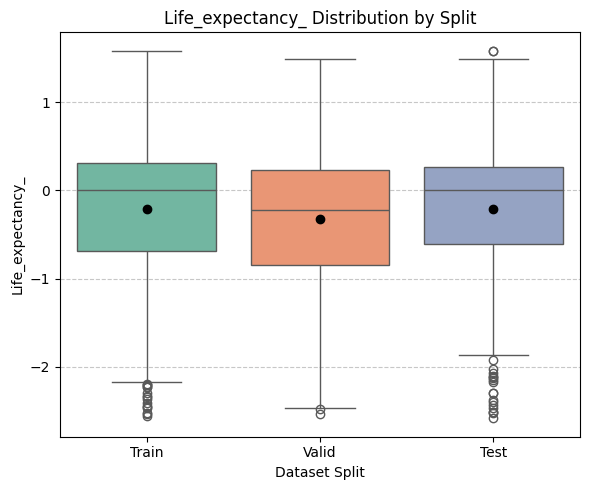

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


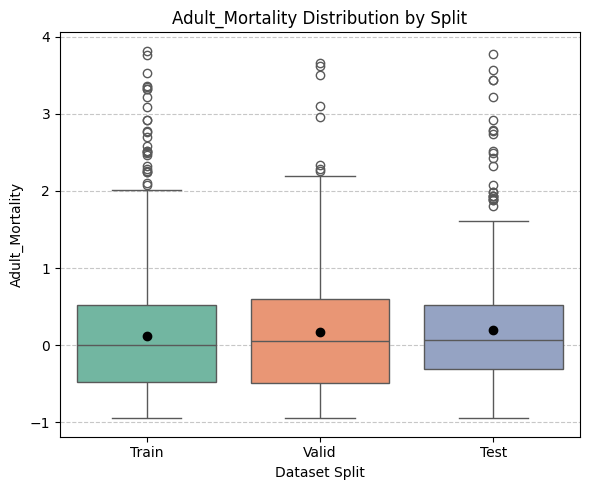

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


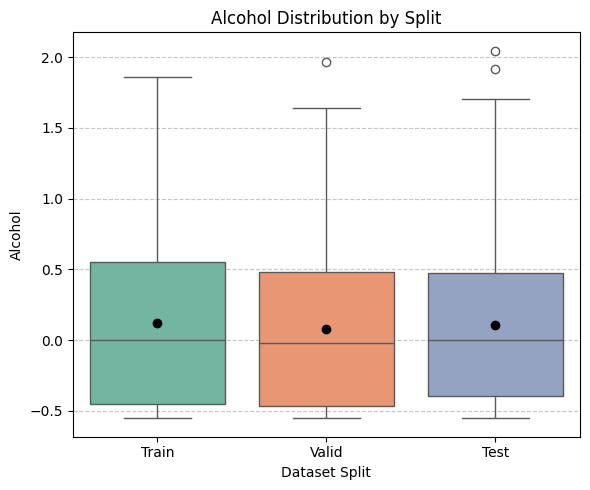

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


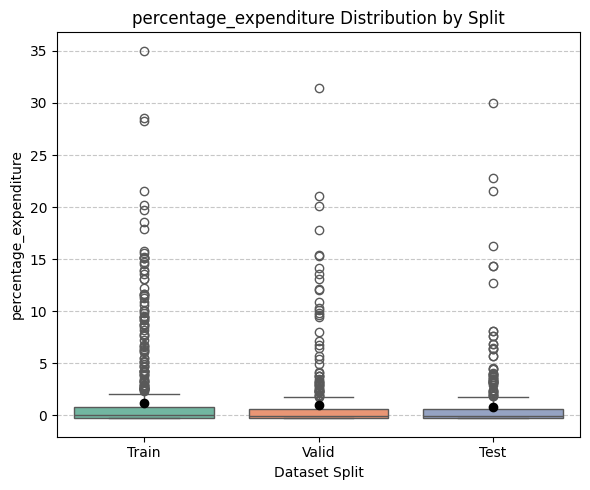

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


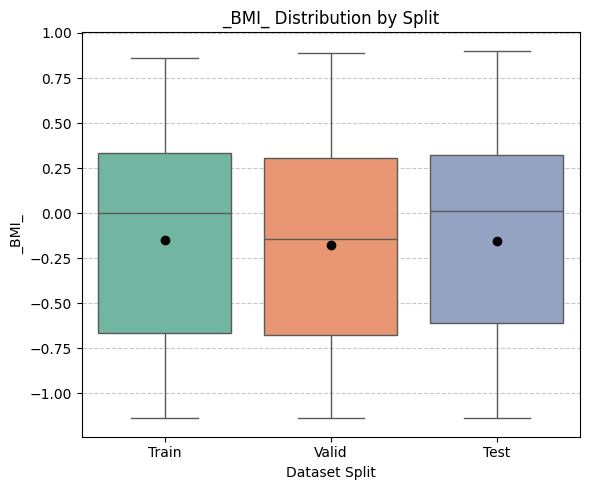

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


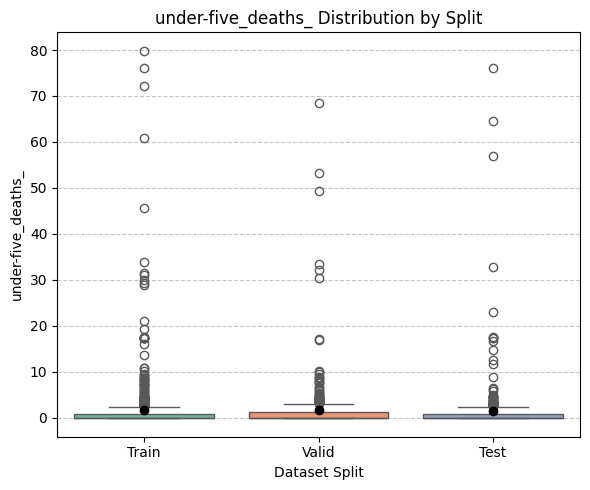

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


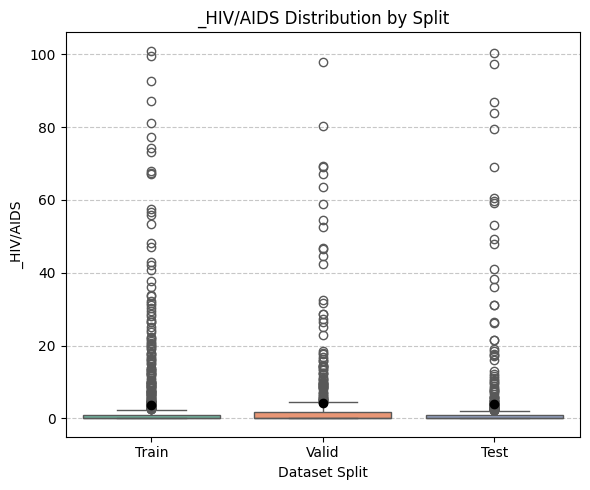

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


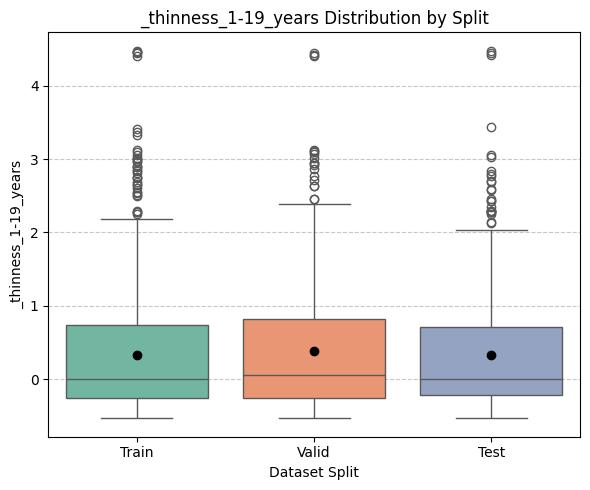

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


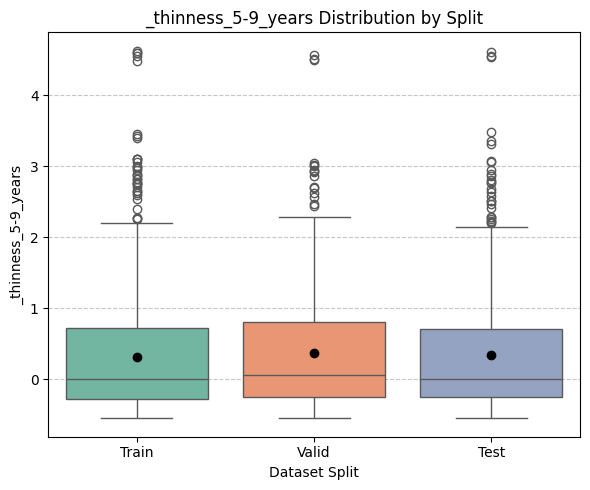

<ipython-input-117-9fc789c4d815>:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,


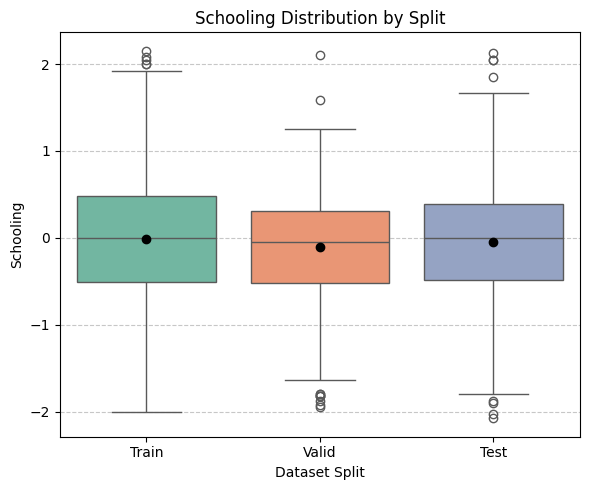

In [ ]:
# Box Plots per column per sets to compare data distributions across sets, necessary to assume any biases

def plot_boxplots(train_df, valid_df, test_df):
    # Add a column indicating which set each row comes from
    train_df = train_df.copy()
    train_df["split"] = "Train"

    valid_df = valid_df.copy()
    valid_df["split"] = "Valid"

    test_df = test_df.copy()
    test_df["split"] = "Test"

    # Combine into one dataframe
    combined_df = pd.concat([train_df, valid_df, test_df])

    numeric_cols = combined_df.select_dtypes(include='number').columns.drop('split', errors='ignore')

    # Plot each numeric column
    for col in numeric_cols:
        plt.figure(figsize=(6, 5))
        sns.boxplot(data=combined_df, x="split", y=col, palette="Set2", showmeans=True,
                    meanprops={"marker": "o", "markerfacecolor": "black", "markeredgecolor": "black"})
        plt.title(f"{col} Distribution by Split")
        plt.xlabel("Dataset Split")
        plt.ylabel(col)
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

plot_boxplots(train_df, valid_df, test_df)

In [ ]:
# Split into features and labels per set

X_train = train_df.drop(columns=['Life_expectancy_'])
y_train = train_df['Life_expectancy_']

X_valid = valid_df.drop(columns=['Life_expectancy_'])
y_valid = valid_df['Life_expectancy_']

X_test = test_df.drop(columns=['Life_expectancy_'])
y_test = test_df['Life_expectancy_']

In [ ]:
mean_baseline = df['Life_expectancy_'].mean()
print(mean_baseline)

baseline_preds = [y_test.mean()] * len(y_test)
rmse_baseline = np.sqrt(mean_squared_error(y_test, baseline_preds))
print(f"Baseline RMSE: {rmse_baseline:.3f}")

69.3023044269254
Baseline RMSE: 0.812


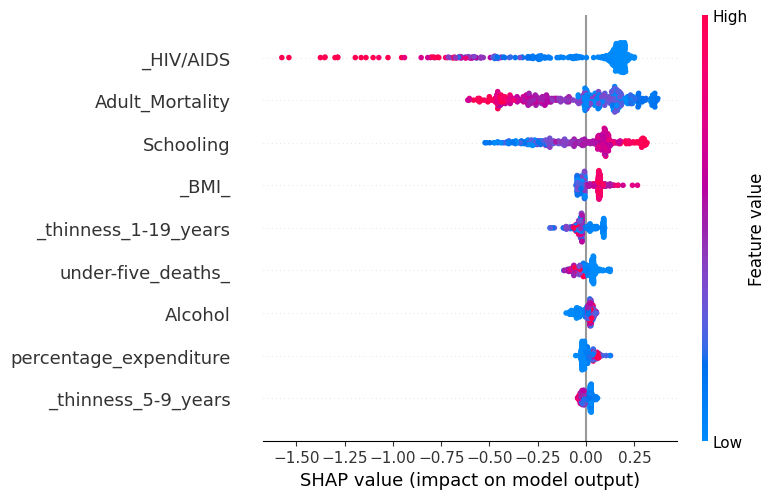

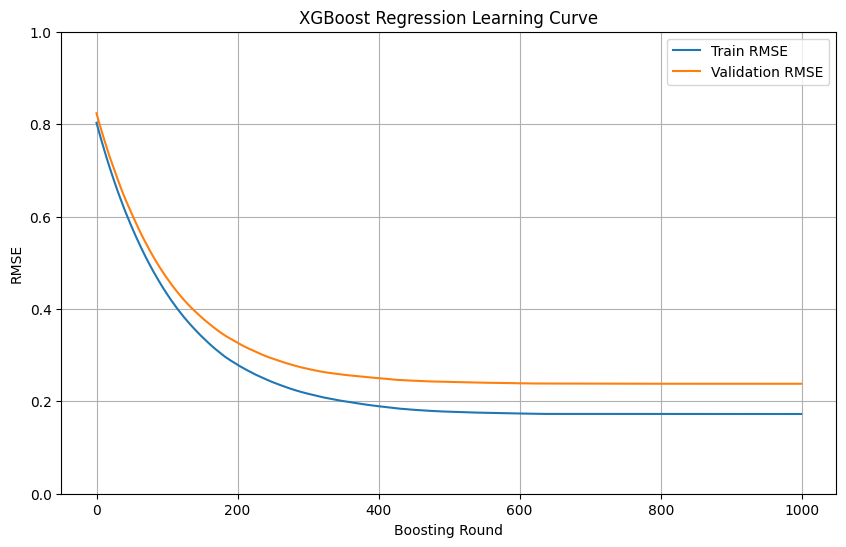

In [ ]:
reg_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.01,
    max_depth=5,
    subsample=1,
    colsample_bytree=1,
    early_stopping_rounds=100,
    eval_metric='rmse',
    gamma=0.20,
    reg_lambda=25,
    random_state=42
)

reg_xgb.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_valid, y_valid)],
    verbose=False
)

# Plot the first tree
#plt.figure(figsize=(20, 10))
#plot_tree(reg_xgb, num_trees=0, rankdir='LR')
#plt.title("Initial Regression Tree (Tree 0)")
#plt.show()

# Shap Analysis
explainer = shap.Explainer(reg_xgb)
shap_values = explainer(X_valid)

shap.summary_plot(shap_values, X_valid)


evals_result = reg_xgb.evals_result()

train_rmse = evals_result['validation_0']['rmse']
valid_rmse = evals_result['validation_1']['rmse']

plt.figure(figsize=(10, 6))
plt.plot(train_rmse, label='Train RMSE')
plt.plot(valid_rmse, label='Validation RMSE')
plt.xlabel('Boosting Round')
plt.ylabel('RMSE')
plt.ylim(0, 1)
plt.title('XGBoost Regression Learning Curve')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Predict
y_train_pred = reg_xgb.predict(X_train)
y_valid_pred = reg_xgb.predict(X_valid)
y_test_pred  = reg_xgb.predict(X_test)

In [ ]:
def evaluate_performance(y_true, y_pred, dataset_name="Dataset"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    print(f"--- {dataset_name} ---")
    print(f"RMSE: {rmse:.4f}")
    print(f"MAE : {mae:.4f}")
    print(f"R²  : {r2:.4f}")
    print()

evaluate_performance(y_train, y_train_pred, "Train")
evaluate_performance(y_valid, y_valid_pred, "Validation")
evaluate_performance(y_test, y_test_pred, "Test")

--- Train ---
RMSE: 0.1726
MAE : 0.1203
R²  : 0.9545

--- Validation ---
RMSE: 0.2380
MAE : 0.1649
R²  : 0.9163

--- Test ---
RMSE: 0.2243
MAE : 0.1537
R²  : 0.9237

